In [1]:
%matplotlib inline

import os
import sys
import shap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from copy import deepcopy
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Any, Union, Optional

from xgboost import XGBClassifier

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score


shap.initjs()

In [20]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=n, random_state=2)
estimator = SVR(kernel="linear")
for i in reversed(range(n)):
    print(i)
    selector = RFECV(estimator, step=1, cv=5, min_features_to_select=i)
    selector = selector.fit(X, y)
    print(selector.support_)
    if selector.support_.sum() == i:
        print("broke")
        break
    else:
        print("continue")


selector.ranking_

9
[ True  True  True  True  True  True  True  True  True  True]
continue
8
[ True  True  True  True  True False  True False  True  True]
broke


array([1, 1, 1, 1, 1, 3, 1, 2, 1, 1])

In [19]:
n=10
[i for i in reversed(range(n))]

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [17]:
#from cancer_package import constants, reporters, preprocessing, transformers
import cancer_package.constants as constants
import cancer_package.reporters as reporters
import cancer_package.preprocessing as preprocessing
import cancer_package.transformers as transformers
import cancer_package.pipeline_tuner as pipeline_tuner
import cancer_package.utilities as utilities

In [7]:
USE_ENERGY_PROTEINS = False
USE_MOCK = False
MULTIPLE_CATEGORIES = False
NON_NAN_THRESH = .7
REPLACE_BY_NAN = False
N_FOLDS = 10

# 1. Preprocessing

## 1.1. Basic preprocessing:
Removing empty columns, shuffling data, computing biological features, removing columns with excess NaNs

original dataset shape: (231, 117)
rm 22 proteins with no data
rm 28 energy proteins


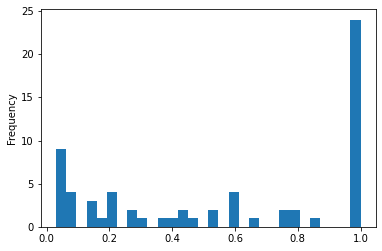

preprocessed dataset shape: (231, 176)
GC           47
LC           33
CTL          33
CCA          25
LD (PM)      23
CRC          22
LD (COPD)    17
BC           17
EC           14
Name: category, dtype: int64


In [8]:
if USE_MOCK:
    data = pd.read_csv( os.path.join(constants.MOCK_DATA_DIRECTORY, 'cancer_and_ld_patients.csv'))
    formulas_df = pd.read_csv( os.path.join(constants.MOCK_DATA_DIRECTORY, 'formulas.csv'))
    protein_group = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'protein_group.csv'))
else:
    data = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'cancer_and_ld_patients.csv'))
    formulas_df = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'formulas.csv'))
    protein_group = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'protein_group.csv'))

# checking we have data
print(f"original dataset shape: {data.shape}")

data_prep = preprocessing.BasicPreprocessing(data, constants.NA_VALUE, USE_ENERGY_PROTEINS)
data_prep.organise_proteins(protein_group)
data_prep.non_nan_share_hist(bins=30)
data_prep.bio_features(formulas_df)
data_prep.rm_execess_nans(NON_NAN_THRESH, by_group=False)

if REPLACE_BY_NAN:
    data_prep.replace_nans()
    print("replaced NaNs")

data = data_prep.data
PROTEINS = data_prep.proteins
FORMULAS_DF = data_prep.formulas_df
FEATURE_NAMES = data_prep.feature_names()

print(f"preprocessed dataset shape: {data.shape}")
print(data.category.value_counts())

## 1.2. Aggregate categories

In [9]:
X_train, y_train = data[FEATURE_NAMES], data["category"]

if MULTIPLE_CATEGORIES:
    category_mapping = {('LD (COPD)', 'LD (PM)'): "LD"}#, ('BC', 'CRC', 'EC'): "OtherC"}
else:
    category_mapping = {
        ('CTL', 'LD (COPD)', 'LD (PM)'): "NonCancer",
        ('GC', 'LC', 'CCA', 'CRC', 'BC', 'EC'): "Cancer"
    }
category_encoder = transformers.MapCategories( category_mapping)
y_train = category_encoder.fit_transform( y_train)

if REPLACE_BY_NAN:
    X_train.fillna(constants.NA_VALUE, inplace=True)

print("verification the transformation went fine")
category_encoder.inverse_transform( y_train).value_counts() / len(y_train)

verification the transformation went fine


Cancer       0.683983
NonCancer    0.316017
Name: category, dtype: float64

# XGB PIPELINE

In [22]:
def create_xgb_pipe():
    """
    Creates a XGBoost model depending on the classification problem type.
    The categories were aggregates such that there are only 2 then it will 
    treat it as a binary problem, if there are more then 2 then it will a
    multiple classification problem.
    
    :raise ValueError: if there is < 2 classes 
    :return: an XGBoost model within a pipeline
    """
    if len(category_encoder.classes_) == 2:
        xgb_model = XGBClassifier(
          objective="binary:logistic",
          n_jobs=-1,  
          #eval_metric="auc", #['mlogloss', 'merror'],
          random_state=666
        )
    elif len(category_encoder.classes_) > 2:
        xgb_model = XGBClassifier(
          objective='multi:sofprob', # 'multi:softmax',
          n_jobs=-1,  
          num_class=len(category_encoder.classes_),
          #eval_metric="mlogloss",
          random_state=666
        )
    else:
        raise ValueError("it isn't possible to have less than 2 classes")

    xgb_pipe = Pipeline(steps=[("model", xgb_model)])

    return xgb_pipe

In [25]:
import importlib
importlib.reload(pipeline_tuner)
importlib.reload(utilities)

<module 'cancer_package.utilities' from '/home/jupyter/cancer_research/cancer_package/utilities.py'>

model save in: xgb_20210322_0913

step 0 starts
-- bayes func: {'model__colsample_bylevel': 0.30726190771998996, 'model__colsample_bynode': 0.651312214504117, 'model__colsample_bytree': 0.6470413051939022, 'model__learning_rate': 0.12676590579185532, 'model__max_depth': 3, 'model__n_estimators': 18, 'model__reg_lambda': 4.185081805104525}
-- bayes func: {'model__colsample_bylevel': 0.4736708178894914, 'model__colsample_bynode': 0.35884175581574507, 'model__colsample_bytree': 0.54184904803528, 'model__learning_rate': 0.1333552693064643, 'model__max_depth': 7, 'model__n_estimators': 29, 'model__reg_lambda': 0.38748375832319826}
-- bayes func: {'model__colsample_bylevel': 0.8825512408986194, 'model__colsample_bynode': 0.5132448460991055, 'model__colsample_bytree': 0.920660354889663, 'model__learning_rate': 0.17695728578202297, 'model__max_depth': 2, 'model__n_estimators': 21, 'model__reg_lambda': 5.5787160551639134}
-- bayes func: {'model__colsample_bylevel': 0.7055697206366967, 'model__c

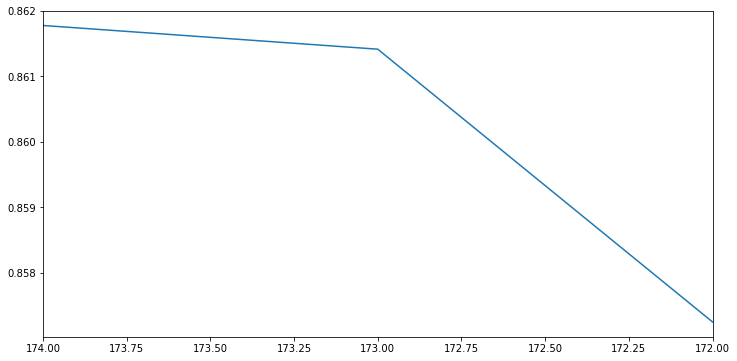

In [26]:
cv_splitter = StratifiedKFold(N_FOLDS, random_state=69, shuffle=True)
w_array = utilities.class_weights(y_train)

xgb_pipe_bounds = {
    'model__max_depth': [2, 8],
    'model__n_estimators': [15, 30],
    'model__learning_rate': [.1, .3],
    'model__reg_lambda': [0, 10],
    'model__colsample_bytree': [.3, 1],
    'model__colsample_bylevel': [.3, 1],
    'model__colsample_bynode': [.3, 1],
}



pipe_tuner = pipeline_tuner.PipelineTuner(
    create_xgb_pipe,
    xgb_pipe_bounds,
    X_train,
    y_train,
    # "roc_auc_ovr_weighted" #"balanced_accuracy" "f1_micro"
    scorer="neg_log_loss", #"neg_log_loss" if len(category_encoder.classes_) > 2 else "roc_auc", 
    cv=cv_splitter,
    weight_array=w_array,
    patience=2,
)

pipe_tuner.bayes_config(
    n_iter = 3,#200,
    init_points = 2,#50,
    discrete_vars = [f"model__{elem}" for elem in  ["max_depth", "n_estimators"]]
)


pipe_tuner.save( constants.RESULTS_DIRECTORY, 'xgb')

#pipe_tuner.continue_tuning(
#    os.path.join(constants.RESULTS_DIRECTORY, 'xgb_20210322_0913', 'model.pkl')
#)

pipe_tuner.tune()
pipe_tuner.plot_tuning()

xgb_best_pipe = pipe_tuner.best_pipe
best_features = pipe_tuner.best_features
fs_pipes = pipe_tuner.fs_pipes
fs_scores = pipe_tuner.fs_scores
fs_features = pipe_tuner.fs_features

1: 170
2: 170



cv f1-macro 47.90%
cv f1-micro 51.52%
cv accuracy score for best tree: 51.52%
cv balanced accuracy for best tree: 48.41%
cv confusion


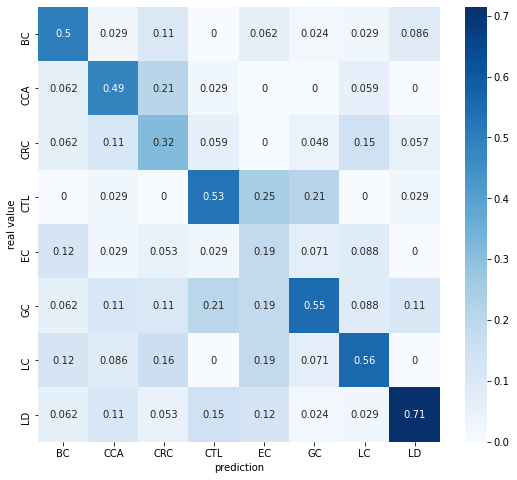

              precision    recall  f1-score   support

          BC       0.50      0.47      0.48        17
         CCA       0.49      0.68      0.57        25
         CRC       0.32      0.27      0.29        22
         CTL       0.53      0.55      0.54        33
          EC       0.19      0.21      0.20        14
          GC       0.55      0.49      0.52        47
          LC       0.56      0.58      0.57        33
          LD       0.71      0.62      0.67        40

    accuracy                           0.52       231
   macro avg       0.48      0.48      0.48       231
weighted avg       0.52      0.52      0.52       231

recall by category


,category,recall
4,EC,0.214286
2,CRC,0.272727
0,BC,0.470588
5,GC,0.489362
3,CTL,0.545455
6,LC,0.575758
8,LD (PM),0.608696
7,LD (COPD),0.647059
1,CCA,0.680000




decision tree feature importance


,name,importance
0,HSPA9 / HSP90AB1,3.14%
1,HSPA9 * ST13,2.58%
2,(HSPB1 + HSPB4 + HSPB5) / HSP90AA1,2.10%
3,HSPA8 * HSP90B1,2.06%
4,ST13 / STIP1,1.85%
5,PPP5C / HSP90AA1,1.78%
6,HSPA9 * HSP90AA1,1.55%
7,(CCT3 + CCT8) / HSP90AA1,1.55%
8,HSPA6 * TRAP1,1.43%
9,CCT2 / HSP90B1,1.43%


importance of each individual feature (ordered)


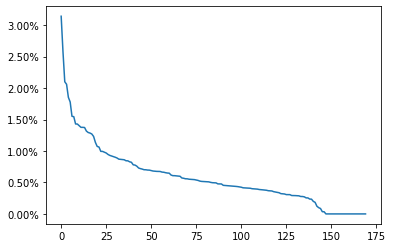

cumulative importance of each feature (ordered)


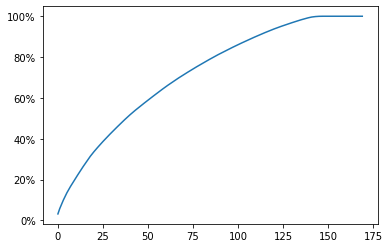

<AxesSubplot:>

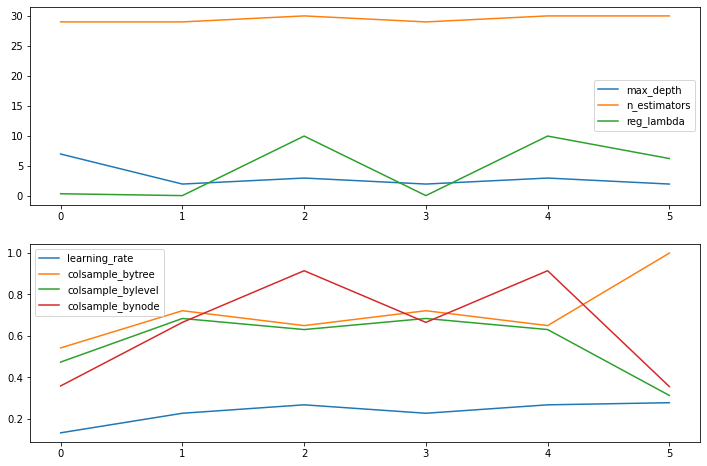

In [84]:
xgb_feat_imp = reporters.report_maker(
    xgb_best_pipe,
    X_train[best_features],
    y_train,
    X_test=None,
    y_test=None,
    category_names=category_encoder.classes_.tolist(),
    categories=data.category.to_list(),
    feature_codes=best_features.tolist(),
    equation_mapping=data_prep.clean_equation_mapping,
    weight_array=w_array,
    cv=cv_splitter
)


all_params = pd.DataFrame([elem["model"].get_params() for elem in fs_pipes])
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
all_params[['max_depth', 'n_estimators', 'reg_lambda']].plot.line(ax=ax[0])
all_params[['learning_rate', 'colsample_bytree', 'colsample_bylevel', 'colsample_bynode']].plot.line(ax=ax[1])

In [131]:
import importlib
importlib.reload(reporters)

<module 'cancer_package.reporters' from '/home/jupyter/cancer_research/cancer_package/reporters.py'>

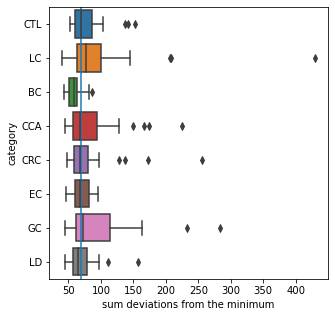

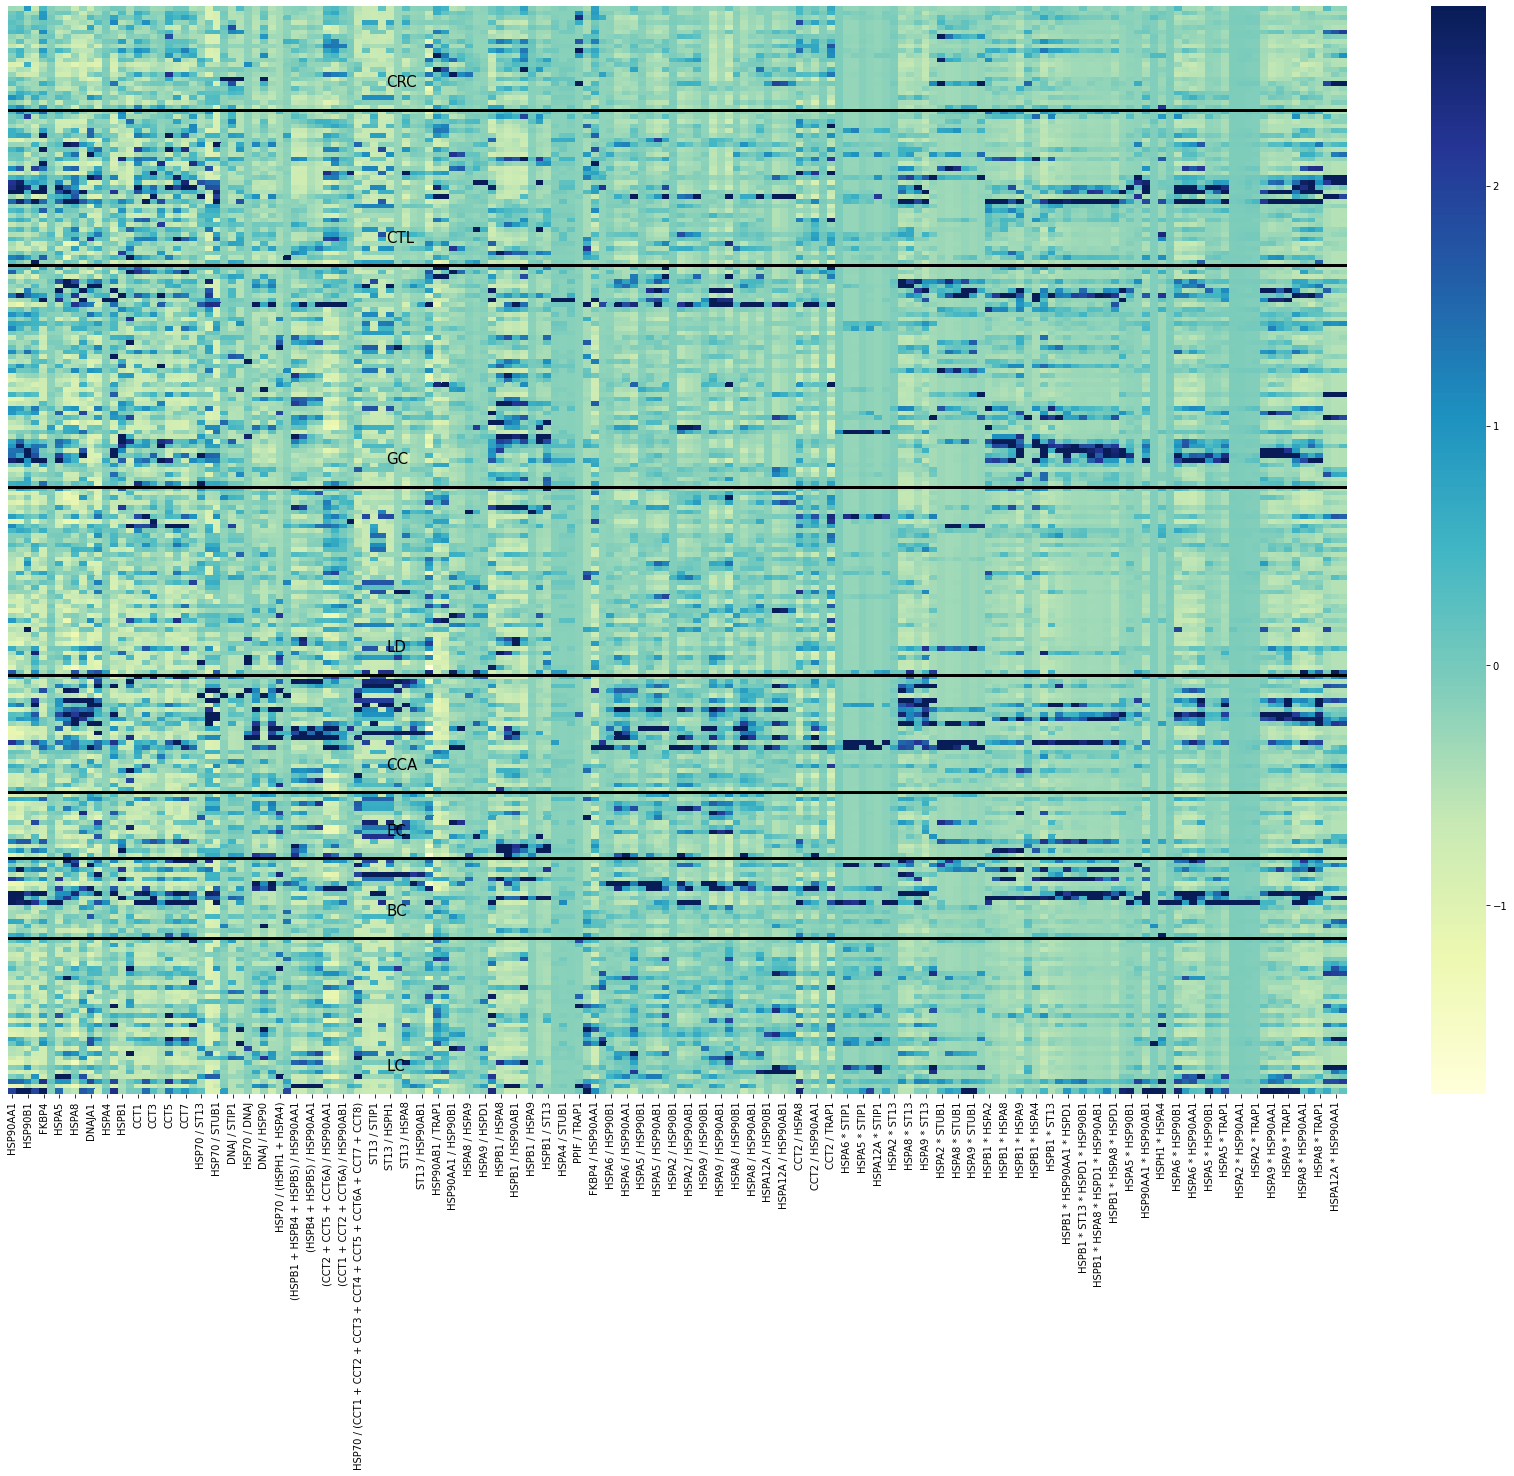

In [132]:
feature_names = pd.Series(fs_features[fs_scores.idxmax()])
heatmap_data = pd.concat([X_train, category_encoder.inverse_transform(y_train)], 1)
reporters.plot_protein_heatmap(
    heatmap_data,
    feature_names,
    feature_mapping=data_prep.clean_equation_mapping,
    group_proteins=False)

In [126]:
pd.DataFrame({"A": [1, -3, -4], "B": [-14, 2, 1]}).abs().sum(axis="columns")

0    15
1     5
2     5
dtype: int64